#### Sept. 22, 2017

Generate input csv files (from breseq output of annotated.gd) for plotting with the following code snippets from ```lost_polymorphisms.py``` and ```plot_polymorphisms.py```:

In [1]:
import numpy as np
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt

In [2]:
## Two relevant functions from class ComparePolymorphisms, in lost_polymorphisms.py

def get_all_gd(self, evolution_line, input_directory, path_to_ancestor_gd):
    '''
    Input1: name of evolution line
    Input2: directory path to all breseq results
    Input3: path to GenomeDiff file for ancestral (generation 0) population.
    Output: GD files for all generations of the evolution line, concatenated as one data frame.
    '''
    ancestor_df = self.annotated_gd_to_df(path_to_ancestor_gd, 0)
    annotated_gd_files = glob.glob(input_directory + '*' + evolution_line + '*/output/*.gd')
    print(annotated_gd_files)
    all_dataframes = [ancestor_df]
    for genome_diff in annotated_gd_files:
        generation = int(genome_diff[-8:-3].split('-')[1])
        dataframe = self.annotated_gd_to_df(genome_diff, generation)
        all_dataframes.append(dataframe)
    evolution_line_dataframe = pd.concat(all_dataframes, ignore_index=True)
    evolution_line_dataframe.insert(0, 'line', evolution_line)
    return evolution_line_dataframe

def gd_frequencies_to_df(self, df_from_all_gd, save_csv=False, csv_filename='gd_freqs.csv'):
    '''
    Input: output from get_all_gd(), i.e., data frame of combined gd files from one evolution line.
    Output: data frame of all polymorphisms with frequencies, for plotting.
    '''
    df_from_all_gd.insert(2, 'consensus_frequency', 'NaN')
    df_from_all_gd.insert(3, 'polymorphism_frequency', 0.0)
    df_from_all_gd.rename(columns = {0: 'entry_type', 1: 'item_id', 2: 'evidence_id', 3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)
    # entry types obtained from http://barricklab.org/twiki/pub/Lab/ToolsBacterialGenomeResequencing/documentation/gd_format.html
    df_polymorphisms = df_from_all_gd[(df_from_all_gd['entry_type'] == 'INS') | (df_from_all_gd['entry_type'] == 'DEL') | 
            (df_from_all_gd['entry_type'] == 'SNP') | (df_from_all_gd['entry_type'] == 'SUB') | (df_from_all_gd['entry_type'] == 'MOB') | 
            (df_from_all_gd['entry_type'] == 'AMP') | (df_from_all_gd['entry_type'] == 'CON') | (df_from_all_gd['entry_type'] == 'INV')].copy()
    for row in df_polymorphisms.itertuples():
        for col_index in range(6, 51):
            if re.match('frequency', str(df_polymorphisms.loc[row[0], col_index])):
                df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('frequency=', '', str(df_polymorphisms.loc[row[0], col_index]))
                if df_polymorphisms.loc[row[0], 'polymorphism_frequency'] == '1':
                    df_polymorphisms.loc[row[0], 'consensus_frequency'] = 1.0
                    evidence_id = df_polymorphisms.loc[row[0], 'evidence_id']
                    evidence_row = df_from_all_gd[df_from_all_gd['item_id'] == evidence_id].index
                    for evidence_col in range(6, 51):
                        if re.match('polymorphism_frequency', str(df_from_all_gd.loc[evidence_row, evidence_col])):
                            df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df_from_all_gd.loc[evidence_row, evidence_col]))
                        break
            break
                
    df_polymorphisms_for_plotting = df_polymorphisms[['line', 'generation', 'entry_type', 'item_id', 'mutation_detail',  
                                                      'genome_id', 'position', 'polymorphism_frequency', 'consensus_frequency']].copy()
    dtype = {'line': str, 'generation': int, 'entry_type': str, 'item_id': str, 'genome_id': str,
             'position': str, 'polymorphism_frequency': float, 'consensus_frequency': float}
    for key, value in dtype.items():
        df_polymorphisms_for_plotting[key] = df_polymorphisms_for_plotting[key].astype(value)
    if save_csv == True:
        df_polymorphisms_for_plotting.to_csv(csv_filename, index=False)
    
    return df_polymorphisms_for_plotting

```
## Script from plot_polymorphisms.py

from lost_polymorphisms import ComparePolymorphisms

input_directory = '~/breseq_results/'
output_directory = '~/plot_polymorphisms/results/'
ancestor_gd_path = input_directory + 'sic_Ancestor_breseq/output/0.gd'
evolution_lines = ['HA3', 'HE3', 'HR2', 'HS3', 'UA3', 'UE3', 'UR1', 'US1']

cp_gd = ComparePolymorphisms()
for line in evolution_lines:
    line_df = cp_gd.get_all_gd(line, input_directory, ancestor_gd_path)
    output_csv = output_directory + line + '_gd_freqs.csv'
    frequencies_df = cp_gd.gd_frequencies_to_df(line_df, save_csv=True, csv_filename=output_csv)
```

In [3]:
all_csv = glob.glob('/Users/ymseah/Repositories/dataviz/data/*_gd_freqs.csv')
df_list = []
for csv in all_csv:
    df = pd.read_csv(csv)
    df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)
all_df['polymorphism'] = all_df['position'].astype(str).str.cat(all_df['entry_type'], sep=' ').str.cat(all_df['mutation_detail'], sep=' ')
all_df = all_df[['line', 'genome_id', 'generation', 'polymorphism', 'polymorphism_frequency']].copy()
all_df_pvt = all_df.pivot_table(index=['genome_id', 'line', 'generation'], columns='polymorphism', values='polymorphism_frequency')

In [4]:
dvh_df = all_df_pvt.loc['NC_002937'].dropna(axis=1, how='all')
mm_df = all_df_pvt.loc['NC_005791'].dropna(axis=1, how='all')
dvplasmid_df = all_df_pvt.loc['NC_005863'].dropna(axis=1, how='all')

In [101]:
def fluctuating_bools(df):
    '''
    Returns 2 lists of alternating bool values. List length is the number of indexes in df.
    '''
    indices = df.index.tolist()
    true_false = []
    false_true = []
    count = 0
    while count < len(indices):
        true_false.append(True)
        false_true.append(False)
        count += 1
        if count < len(indices):
            true_false.append(False)
            false_true.append(True)
            count += 1
    return true_false, false_true

def greater_than_last_gen(df):
    '''Compares if frequencies in each row greater than in previous row, 
    returns df of bool values'''
    comparisons = {}
    count = 0
    while count < len(df.index)-1:
        comparisons[str(count+1) + '_to_' + str(count)] = df.loc[df.index[count+1]] > df.loc[df.index[count]]
        count += 1
    compare_df = pd.DataFrame(comparisons).T
    return compare_df

def subset_fluctuating_frequencies(df):
    '''Returns list of df columns with fluctuating polymorphisms'''
    t_f, f_t = fluctuating_bools(df)
    fluctuating_polymorphisms = []
    for col in df.columns:
        if (df[col].tolist() == t_f) | (df[col].tolist() == f_t):
            fluctuating_polymorphisms.append(col)
    return fluctuating_polymorphisms
    
def subset_monotonic(df):
    '''
    Returns 2 lists of column names that have monotonically increasing, and decreasing values. 
    '''
    mono_inc = []
    mono_dec = []
    for col in df.columns:
        if df[col].is_monotonic_increasing:
            mono_inc.append(col)
        elif df[col].is_monotonic_decreasing:
            mono_dec.append(col)
    return mono_inc, mono_dec

# Plotting functions

def plot_fluctuating(df):
    compare_freqs = greater_than_last_gen(df)
    flux = subset_fluctuating_frequencies(compare_freqs)
    df[flux].plot().legend(loc='upper right')

def plot_line_summary(line, df, plottitle):
    data = df.loc[line.upper()].dropna(axis=1, how='all').fillna(0)
    # monotonic
    inc, dec = subset_monotonic(data)
    fig, axes = plt.subplots(4,1, sharex=True)
    if len(inc) > 0:
        data[inc].plot(ax=axes[0], legend=False, title=plottitle)
    else:
        axes[0].set_title(plottitle)
    if len(dec) > 0:
        data[dec].plot(ax=axes[1], legend=False)
    # fluctuating
    compare_freqs = greater_than_last_gen(data)
    flux = subset_fluctuating_frequencies(compare_freqs)
    if len(flux) > 0:
        data[flux].plot(ax=axes[2], legend=False)
    # others
    oth = []
    for col in data.columns:
        if (col in inc) | (col in dec) | (col in flux):
            break
        else:
            oth.append(col)
    if len(oth) > 0:
        data[oth].plot(ax=axes[3], legend=False)
    plt.savefig(plottitle + '_summary.png')

def plot_line_individual(line, df, genome_id):
    data = df.loc[line.upper()].dropna(axis=1, how='all').fillna(0)
    inc, dec = subset_monotonic(data)
    compare_freqs = greater_than_last_gen(data)
    flux = subset_fluctuating_frequencies(compare_freqs)

    if len(inc) > 0:
        data[inc].plot(title = line.upper() + ':' + genome_id + ' is_monotonic_increasing', figsize=(20,15)).legend(loc='upper left', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_monotonic_increasing.png')
    if len(dec) > 0:
        data[dec].plot(title = line.upper() + ':' + genome_id + ' is_monotonic_decreasing', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_monotonic_decreasing.png')
    if len(flux) > 0:
        data[flux].plot(title = line.upper() + ':' + genome_id + ' fluctuating', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_fluctuating.png')
    oth = []
    for col in data.columns:
        if (col in inc) | (col in dec) | (col in flux):
            break
        else:
            oth.append(col)
    if len(oth) > 0:
        data[oth].plot(title = line.upper() + ':' + genome_id + ' others', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_others.png')

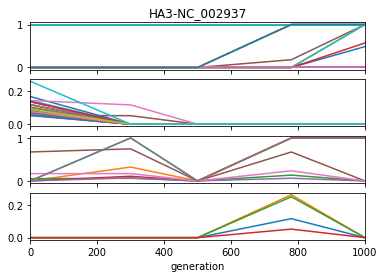

In [98]:
%matplotlib inline
plot_line_summary('ha3', dvh_df, 'HA3-NC_002937')

##### R/RStudio envy resulted in...

R code to tidy and plot data initially, with much help from [R for Data Science](http://r4ds.had.co.nz/tidy-data.html#missing-values-3). ~~Will rewrite this in Python, once I've learned it!~~ *Done!*

```
# In plotfreqs.R

library(tidyverse)

get_polymorphisms <- function(filepath) {
  polymorphisms <- read.csv(filepath) %>% 
    unite(polymorphism, position, entry_type, mutation_detail, sep = ' ') %>%
    select(genome_id, polymorphism, generation, polymorphism_frequency) %>% 
    complete(nesting(polymorphism, genome_id), generation, fill = list(polymorphism_frequency = 0))
  return(polymorphisms)
}

plot_polymorphism_frequencies <- function(polymorphism_tibble, output_dir) {
  ggplot(data = polymorphism_tibble, mapping = aes(x = generation, y = polymorphism_frequency)) + 
    geom_line(aes(group = polymorphism)) + 
    facet_wrap(~ genome_id, ncol = 1)
  ggsave(paste(output_dir, 'polymorphism_plot.png', sep = ''), last_plot())
}

# In plot_genotypes.R

source('~/plotfreqs.R')

ue3polymorphisms = get_polymorphisms('~/data/UE3_gd_freqs.csv')
write.csv(ue3polymorphisms, file = '~/ue3polymorphisms.csv', row.names = FALSE, quote = FALSE)
plot_polymorphism_frequencies(ue3polymorphisms, '~/viz/')
```